In [1]:
import random
import pandas as pd 
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import confusion_matrix_pretty_print
from confusion_matrix_pretty_print import plot_confusion_matrix_from_data

from sklearn.metrics import confusion_matrix,classification_report,precision_score, auc, precision_recall_curve, roc_curve

import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Softmax, Dropout
from keras import optimizers
from keras import metrics as kmetr
from keras.utils import plot_model


In [2]:
zeros = pd.read_csv('../../probZeroDrug30000.csv')

In [3]:
dataTrain = pd.read_csv('../../tripleTrain42702.csv')
dataTest = pd.read_csv('../../tripleTest42702.csv')


In [4]:
r,c = zeros.shape
r,c

(30000, 1139)

In [5]:
ZeroTestIndex = list(range(0 * 3000,10 * 3000))

In [6]:
len(ZeroTestIndex)

30000

In [7]:
dataTrain = pd.concat([dataTrain, zeros.iloc[:int(0.9*r),:]], ignore_index = True) 
dataTrain.shape

(65432, 1139)

In [8]:
dataTest = pd.concat([dataTest, zeros.iloc[int(0.9*r):,:]], ignore_index = True) 
dataTest.shape

(7270, 1139)

In [9]:
del zeros
# del probableZero

In [10]:
# Shuffle datasets
dataTrain = dataTrain.sample(frac=1).reset_index(drop=True)
dataTest = dataTest.sample(frac=1).reset_index(drop=True)

In [11]:
dataTrain.head()

,0,1,2,3,4,5,6,7,8,9,...,1131,1132,1133,1134,1135,1136,1137,1138,1139,1140
0,DB02703,DB01184,1,0.001589,0.001616,0.002213,0.002057,0.001620,0.001970,0.001615,...,0.001970,0.001597,0.001628,0.001582,0.001859,0.001730,0.001777,0.001681,0.001718,0.001653
1,DB00368,DB00575,0,0.001583,0.001632,0.001711,0.001587,0.001630,0.001588,0.001756,...,0.001723,0.001597,0.001645,0.001605,0.001618,0.001601,0.001617,0.001641,0.001613,0.001673
2,DB00652,DB00732,1,0.001570,0.001617,0.001691,0.001615,0.001578,0.001624,0.002041,...,0.001568,0.001751,0.001628,0.001558,0.001628,0.001559,0.001548,0.001613,0.001678,0.001600
3,DB00780,DB00494,1,0.001688,0.001595,0.001570,0.001688,0.001584,0.001616,0.001721,...,0.001650,0.001962,0.001593,0.001571,0.001804,0.001577,0.001573,0.001661,0.002066,0.001609
4,DB00593,DB00375,0,0.001634,0.002286,0.001598,0.001633,0.001590,0.001635,0.001663,...,0.001593,0.001622,0.001744,0.001579,0.001598,0.001573,0.001579,0.001618,0.001597,0.001627


In [12]:
X_train = dataTrain.values[:,3:]
y_train = dataTrain.values[:,2].astype(int)
del dataTrain
trainNum = len(X_train)
X_test = dataTest.values[:,3:]
y_test = dataTest.values[:,2].astype(int)
# del dataTest
testNum = len(X_test)

#reshape data to fit model
X_train = X_train.reshape(trainNum,16,71,1).astype('float32')
X_test = X_test.reshape(testNum,16,71,1).astype('float32')

y_train = y_train + 1
y_test  = y_test + 1
# y_train = y_train / 2
# y_test  = y_test / 2
# print(y_train[0], y_test[0])

#one-hot encode target column
y_train = to_categorical(y_train).astype(int)
y_test = to_categorical(y_test).astype(int)
# y_test[0]


In [13]:
print(y_train[1], y_test[0])

[0 1 0] [0 0 1]


In [14]:
#create model
model = Sequential()
#add model layers
# kernel_initializer='uniform',
# kernel_initializer='uniform',
# kernel_initializer='uniform',
# kernel_initializer='uniform',
model.add(Conv2D(128, kernel_size=4, activation='relu', input_shape=(16,71,1)))
# model.add(Conv2D(64, kernel_size=2, activation='relu'))

model.add(Conv2D(32, kernel_size=4, activation='relu'))
# model.add(Conv2D(16, kernel_size=2, activation='relu'))
model.add(Conv2D(8, kernel_size=4, activation='relu'))
model.add(Flatten())
model.add(Dense( 64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense( 16, activation='relu'))
model.add(Dense( 3, activation='sigmoid'))
# model.add(Softmax(128))
model.summary()

#compile model using accuracy to measure model performance


adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999)
# model.compile(loss='hinge', optimizer=adam, metrics=[kmetr.categorical_accuracy])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 

### Load the model's saved weights.
# model.load_weights('modelTripleDDIPrediction_16_Epoch.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 13, 68, 128)       2176      
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 65, 32)        65568     
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 62, 8)          4104      
                                                                 
 flatten (Flatten)           (None, 3472)              0         
                                                                 
 dense (Dense)               (None, 64)                222272    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                1

In [15]:
##### plotting model
# plot_model(model,show_shapes = True, to_file='modelTripleDDIPrediction.png')

In [18]:
# #### train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=16)
# model.fit(X_train, y_train, epochs=10)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 65800 samples, validate on 6902 samples
Epoch 1/16
65800/65800 [==============================] - 328s 5ms/step - loss: 0.6212 - acc: 0.7284 - val_loss: 0.4475 - val_acc: 0.8122
Epoch 2/16
65800/65800 [==============================] - 322s 5ms/step - loss: 0.4002 - acc: 0.8335 - val_loss: 0.3469 - val_acc: 0.8576
Epoch 3/16
65800/65800 [==============================] - 322s 5ms/step - loss: 0.3196 - acc: 0.8675 - val_loss: 0.2892 - val_acc: 0.8866
Epoch 4/16
65800/65800 [==============================] - 323s 5ms/step - loss: 0.2664 - acc: 0.8905 - val_loss: 0.2524 - val_acc: 0.9018
Epoch 5/16
65800/65800 [==============================] - 322s 5ms/step - loss: 0.2284 - acc: 0.9063 - val_loss: 0.2312 - val_acc: 0.9090
Epoch 6/16
65800/65800 [==============================] - 322s 5ms/step - loss: 0.2047 - acc: 0.9171 - val_loss: 0.2170 - val_acc: 0.9180
Epoch 7/16
65800/65800 [=====

In [19]:
### Saveing the Model
model.save_weights('Weight/modelTripleDDIPrediction_16_Epoch.h5')


In [16]:
predit = model.predict(X_test)
#actual results for first 4 images in test set
# print(predit[:4],X_test[:4,2])

228/228 [==============================] - 4s 18ms/step


In [17]:
print(predit[:4])

[[1.6261604e-01 1.8249569e-04 9.4567603e-01]
 [8.2350075e-03 9.9465430e-01 5.0571296e-02]
 [9.8398639e-05 5.1744711e-01 9.7705036e-01]
 [3.4471464e-04 9.9998885e-01 4.7191896e-02]]


In [18]:
# #from sklearn.metrics import precision_recall_curve, roc_curve

prec, rec, thr = precision_recall_curve(y_test[:,0], predit[:,0])
aupr_val = auc(rec, prec)
fpr, tpr, thr = roc_curve(y_test[:,0], predit[:,0])
auc_val = auc(fpr, tpr)
print(aupr_val,auc_val, " -1s AUPR and AUC")
print('''
Epoch 03: 72 Aupr
Epoch 04: 76 Aupr
Epoch 05: 78 Aupr
Epoch 06: 79 Aupr
Epoch 07: 80 Aupr
Epoch 08: 82 Aupr
Epoch 09: 81 Aupr
Epoch 10: 82 Aupr
Epoch 11: 79 Aupr
Epoch 12: 79 Aupr
Epoch 13: 80 Aupr
Epoch 13: 81 Aupr
''')

0.8797460507747135 0.9745276446422457  -1s AUPR and AUC

Epoch 03: 72 Aupr
Epoch 04: 76 Aupr
Epoch 05: 78 Aupr
Epoch 06: 79 Aupr
Epoch 07: 80 Aupr
Epoch 08: 82 Aupr
Epoch 09: 81 Aupr
Epoch 10: 82 Aupr
Epoch 11: 79 Aupr
Epoch 12: 79 Aupr
Epoch 13: 80 Aupr
Epoch 13: 81 Aupr



In [19]:
# #from sklearn.metrics import precision_recall_curve, roc_curve

prec, rec, thr = precision_recall_curve(y_test[:,2], predit[:,2])
aupr_val = auc(rec, prec)
fpr, tpr, thr = roc_curve(y_test[:,2], predit[:,2])
auc_val = auc(fpr, tpr)
print(aupr_val,auc_val, " +1s AUPR and AUC")
print('''
Epoch 03: 95 Aupr
Epoch 04: 96 Aupr
Epoch 05: 96 Aupr
Epoch 06: 96 Aupr
Epoch 07: 96 Aupr
Epoch 08: 97 Aupr
Epoch 09: 97 Aupr
Epoch 10: 97 Aupr
Epoch 11: 95 Aupr
Epoch 12: 95 Aupr
Epoch 13: 95 Aupr
''')

0.9722557932293452 0.9750455376180324  +1s AUPR and AUC

Epoch 03: 95 Aupr
Epoch 04: 96 Aupr
Epoch 05: 96 Aupr
Epoch 06: 96 Aupr
Epoch 07: 96 Aupr
Epoch 08: 97 Aupr
Epoch 09: 97 Aupr
Epoch 10: 97 Aupr
Epoch 11: 95 Aupr
Epoch 12: 95 Aupr
Epoch 13: 95 Aupr



In [20]:
# #from sklearn.metrics import precision_recall_curve, roc_curve

prec, rec, thr = precision_recall_curve(y_test[:,1], predit[:,1])
aupr_val = auc(rec, prec)
fpr, tpr, thr = roc_curve(y_test[:,1], predit[:,1])
auc_val = auc(fpr, tpr)
print(aupr_val,auc_val, " 0s AUPR and AUC")
print('''
Epoch 03: 95 Aupr
Epoch 03: 96 Aupr
Epoch 05: 96 Aupr
Epoch 06: 96 Aupr
Epoch 07: 96 Aupr
Epoch 08: 96 Aupr
Epoch 09: 97 Aupr
Epoch 10: 96 Aupr
Epoch 11: 96 Aupr
Epoch 12: 96 Aupr
Epoch 13: 96 Aupr
''')

0.9703073823894517 0.9814614754098361  0s AUPR and AUC

Epoch 03: 95 Aupr
Epoch 03: 96 Aupr
Epoch 05: 96 Aupr
Epoch 06: 96 Aupr
Epoch 07: 96 Aupr
Epoch 08: 96 Aupr
Epoch 09: 97 Aupr
Epoch 10: 96 Aupr
Epoch 11: 96 Aupr
Epoch 12: 96 Aupr
Epoch 13: 96 Aupr



In [23]:
history.history

{}

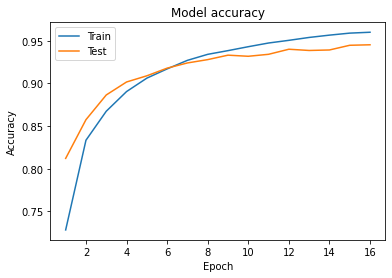

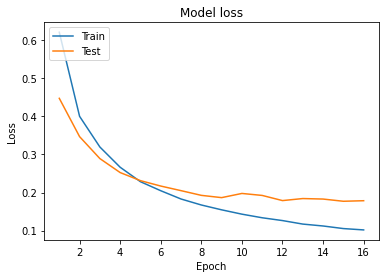

In [42]:

# Plot training & validation accuracy values
plt.plot(list(range(1,17)),history.history['accuracy'])
plt.plot(list(range(1,17)),history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(list(range(1,17)),history.history['loss'])
plt.plot(list(range(1,17)),history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [27]:
# # predit
# predit[:,0].shape 

In [24]:
predicts = []
for a,b,c in predit:
    if a >b and a>c:
        predicts.append(0)
    elif c>a and c>b:
        predicts.append(2)
    else:
        predicts.append(1)

In [25]:
predicts1 = []
e = d = z = 0

for a,b,c in predit:
    if a >=0.95:
        predicts1.append(0)
        d += 1
    elif b>=0.95:
        predicts1.append(2)
        e += 1
    elif a<=0.2 and b<=0.2:
        predicts1.append(1)
        z += 1
    elif c>a and c>b:
        predicts1.append(1)
        z += 1
print('degrassive', d, 'enhancive', e, 'zeros', z)
print('''
Epoch 03: degrassive 195 enhancive 732 zeros 3609
Epoch 04: degrassive 209 enhancive 747 zeros 3649
Epoch 05: degrassive 218 enhancive 720 zeros 3663
Epoch 06: degrassive 244 enhancive 797 zeros 3722
Epoch 07: degrassive 221 enhancive 848 zeros 3721
Epoch 08: degrassive 206 enhancive 729 zeros 3821
Epoch 09: degrassive 155 enhancive 961 zeros 3838
Epoch 10: degrassive 155 enhancive 750 zeros 3960
Epoch 11: degrassive 375 enhancive 1254 zeros 3476
Epoch 12: degrassive 395 enhancive 1093 zeros 3571
Epoch 13: degrassive 273 enhancive 873 zeros 3590
''')

degrassive 811 enhancive 2625 zeros 3182

Epoch 03: degrassive 195 enhancive 732 zeros 3609
Epoch 04: degrassive 209 enhancive 747 zeros 3649
Epoch 05: degrassive 218 enhancive 720 zeros 3663
Epoch 06: degrassive 244 enhancive 797 zeros 3722
Epoch 07: degrassive 221 enhancive 848 zeros 3721
Epoch 08: degrassive 206 enhancive 729 zeros 3821
Epoch 09: degrassive 155 enhancive 961 zeros 3838
Epoch 10: degrassive 155 enhancive 750 zeros 3960
Epoch 11: degrassive 375 enhancive 1254 zeros 3476
Epoch 12: degrassive 395 enhancive 1093 zeros 3571
Epoch 13: degrassive 273 enhancive 873 zeros 3590



In [26]:
# max(list((dataTest.values[:,2]+1)/2))

[[ 773   32   45]
 [ 102 2911  133]
 [  45   57 3172]]
              precision    recall  f1-score   support

           0       0.91      0.84      0.87       920
           1       0.93      0.97      0.95      3000
           2       0.97      0.95      0.96      3350

    accuracy                           0.94      7270
   macro avg       0.93      0.92      0.93      7270
weighted avg       0.94      0.94      0.94      7270



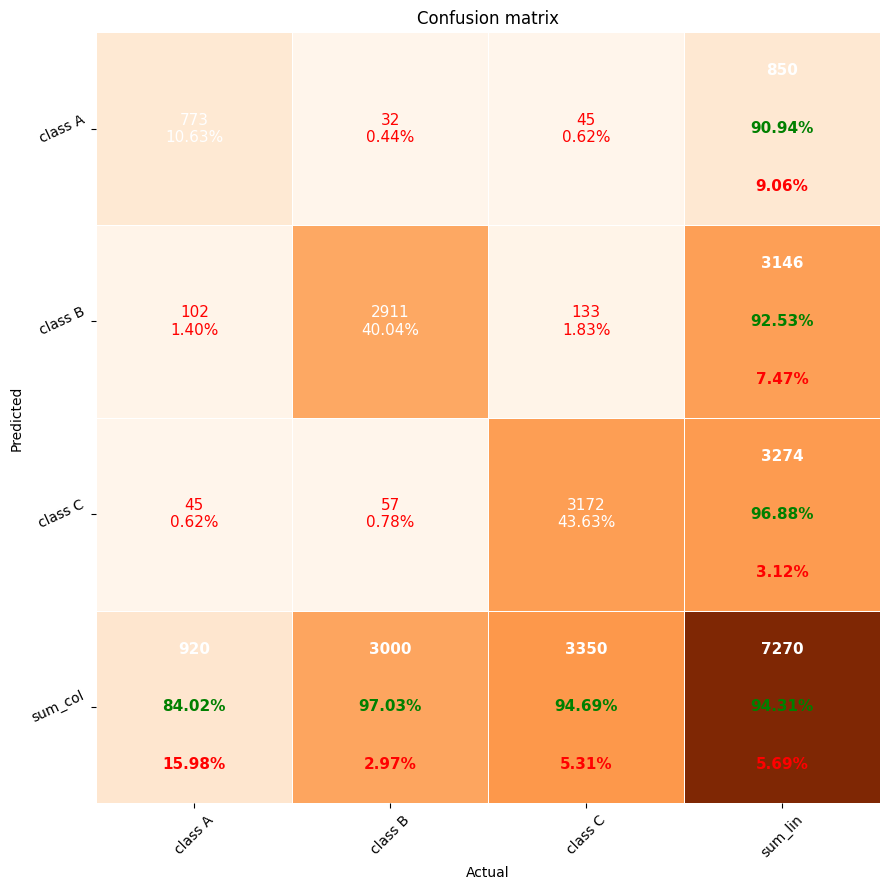


Epoch 03: 
              precision    recall  f1-score   support

           0       0.79      0.67      0.72       914
           1       0.93      0.94      0.93      2000
           2       0.92      0.95      0.93      3396
Epoch 04:
              precision    recall  f1-score   support

           0       0.84      0.71      0.77       914
           1       0.93      0.95      0.94      2000
           2       0.93      0.96      0.95      3396
Epoch 05:
              precision    recall  f1-score   support

           0       0.85      0.75      0.80       914
           1       0.94      0.97      0.95      2000
           2       0.95      0.96      0.95      3396
Epoch 06:
              precision    recall  f1-score   support

           0       0.85      0.77      0.81       914
           1       0.94      0.96      0.95      2000
           2       0.95      0.96      0.95      3396
Epoch 07:
              precision    recall  f1-score   support

           0       0.87  

In [27]:

cm = confusion_matrix(list(predicts), list((dataTest.values[:,2]+1)))
print(cm)

CR = classification_report(list((dataTest.values[:,2]+1)),list(predicts))
print(CR)
# print((92+90+140+67+42+81)/(6950))
# i=0
# for j in list(data.values[9500:,2]+1):
#     if j==1:
#         i +=1
# print(i)

# plt.show()
plot_confusion_matrix_from_data(list((dataTest.values[:,2]+1)), list(predicts))
plt.show()
print("""
Epoch 03: 
              precision    recall  f1-score   support

           0       0.79      0.67      0.72       914
           1       0.93      0.94      0.93      2000
           2       0.92      0.95      0.93      3396
Epoch 04:
              precision    recall  f1-score   support

           0       0.84      0.71      0.77       914
           1       0.93      0.95      0.94      2000
           2       0.93      0.96      0.95      3396
Epoch 05:
              precision    recall  f1-score   support

           0       0.85      0.75      0.80       914
           1       0.94      0.97      0.95      2000
           2       0.95      0.96      0.95      3396
Epoch 06:
              precision    recall  f1-score   support

           0       0.85      0.77      0.81       914
           1       0.94      0.96      0.95      2000
           2       0.95      0.96      0.95      3396
Epoch 07:
              precision    recall  f1-score   support

           0       0.87      0.78      0.82       914
           1       0.94      0.97      0.95      2000
           2       0.96      0.96      0.96      3396
Epoch 08: 
              precision    recall  f1-score   support

           0       0.88      0.81      0.84       914
           1       0.95      0.97      0.96      2000
           2       0.95      0.96      0.96      3396
Epoch 09:
              precision    recall  f1-score   support

           0       0.92      0.76      0.83       914
           1       0.93      0.98      0.95      2000
           2       0.96      0.97      0.96      3396
Epoch 10:
              precision    recall  f1-score   support

           0       0.90      0.79      0.84       914
           1       0.95      0.97      0.96      2000
           2       0.96      0.97      0.96      3396
""")

In [28]:
# print(pd.DataFrame(predit))

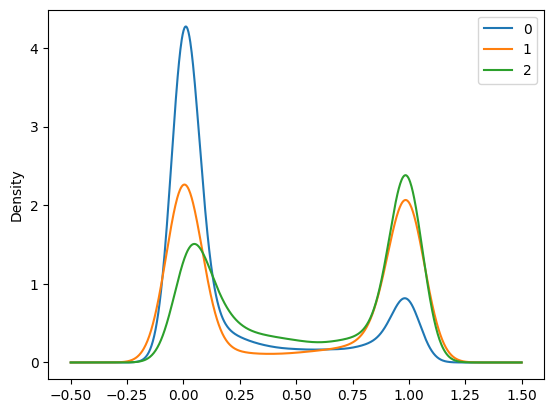

In [29]:
pd.DataFrame(predit).plot.density()
plt.show()

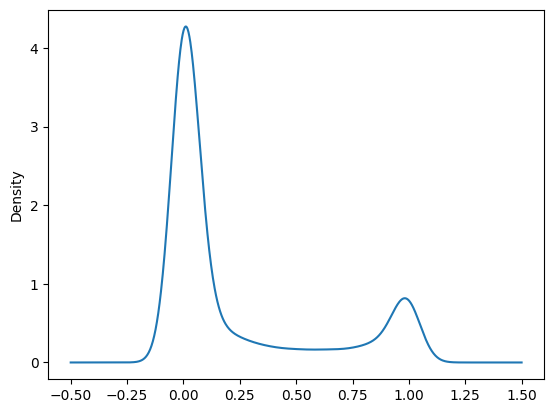

In [30]:
pd.DataFrame(predit).iloc[:,0].plot.density()
plt.show()

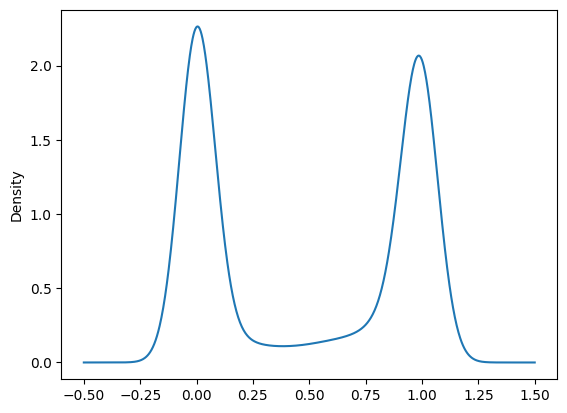

In [31]:
pd.DataFrame(predit).iloc[:,1].plot.density()
plt.show()

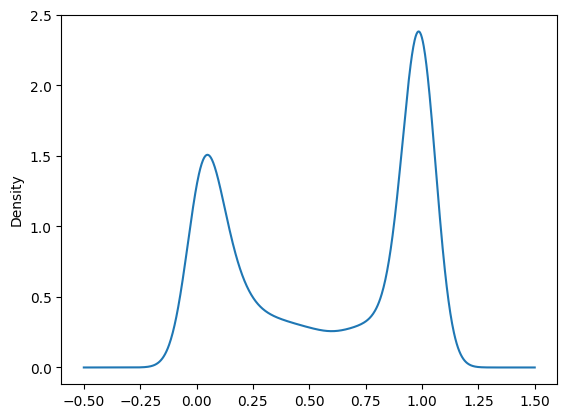

In [32]:
pd.DataFrame(predit).iloc[:,2].plot.density()
plt.show()

C:\Users\Akhod\AppData\Local\Temp\ipykernel_18396\1529948011.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pd.DataFrame(predit).iloc[:,0], hist=True, kde=False,


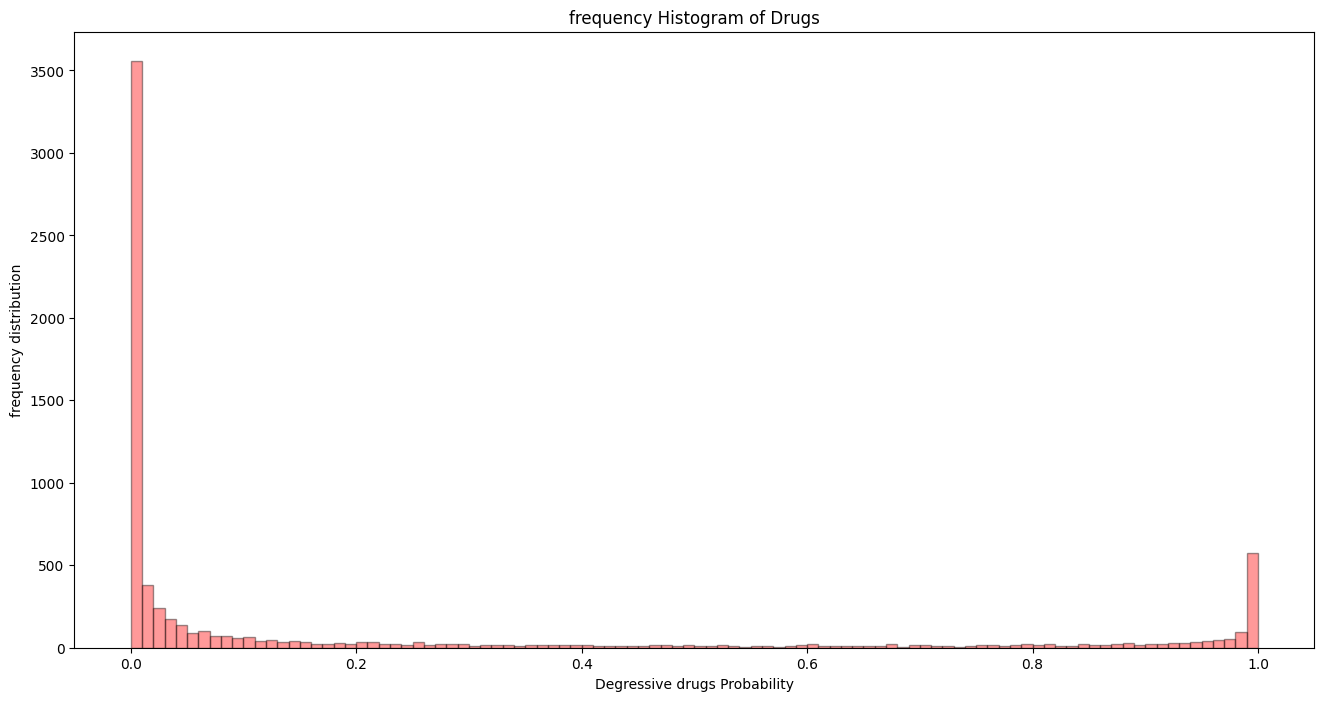

In [33]:

fig, ax = plt.subplots()
fig.set_size_inches(16,8)

# matplotlib histogram
# plt.hist(pd.DataFrame(predit).iloc[:,1], color = 'blue', edgecolor = 'black',
#          bins = int(200))

# seaborn histogram

sns.distplot(pd.DataFrame(predit).iloc[:,0], hist=True, kde=False, 
             bins=int(100), color = 'red',
             hist_kws={'edgecolor':'black'})
# sns.distplot(pd.DataFrame(predit).iloc[:,0], hist=True, kde=True, 
#              bins=int(200), color = 'darkblue', 
#              hist_kws={'edgecolor':'black'},
#              kde_kws={'linewidth': 4})
# Add labels
plt.title('frequency Histogram of Drugs')
plt.xlabel('Degressive drugs Probability')
plt.ylabel('frequency distribution')
plt.show()

C:\Users\Akhod\AppData\Local\Temp\ipykernel_18396\4070980238.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pd.DataFrame(predit).iloc[:,1], hist=True, kde=False,


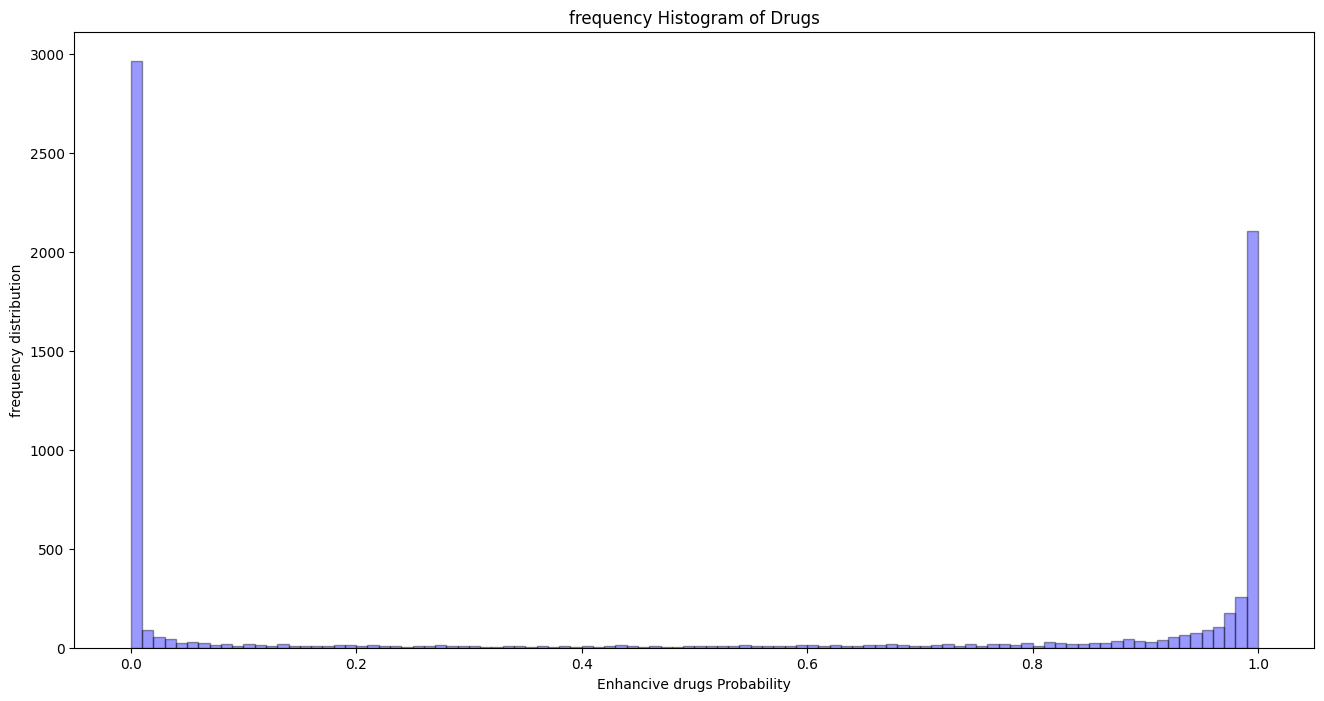

In [34]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 8)

# matplotlib histogram
# plt.hist(pd.DataFrame(predit).iloc[:,1], color = 'blue', edgecolor = 'black',
#          bins = int(200))

# seaborn histogram
sns.distplot(pd.DataFrame(predit).iloc[:,1], hist=True, kde=False, 
             bins=int(100), color = 'blue',
             hist_kws={'edgecolor':'black'})

# sns.distplot(pd.DataFrame(predit).iloc[:,0], hist=True, kde=True, 
#              bins=int(200), color = 'darkblue', 
#              hist_kws={'edgecolor':'black'},
#              kde_kws={'linewidth': 4})
# Add labels
plt.title('frequency Histogram of Drugs')
plt.xlabel('Enhancive drugs Probability')
plt.ylabel('frequency distribution')
plt.show()

C:\Users\Akhod\AppData\Local\Temp\ipykernel_18396\3856901034.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pd.DataFrame(predit).iloc[:,2], hist=True, kde=False,


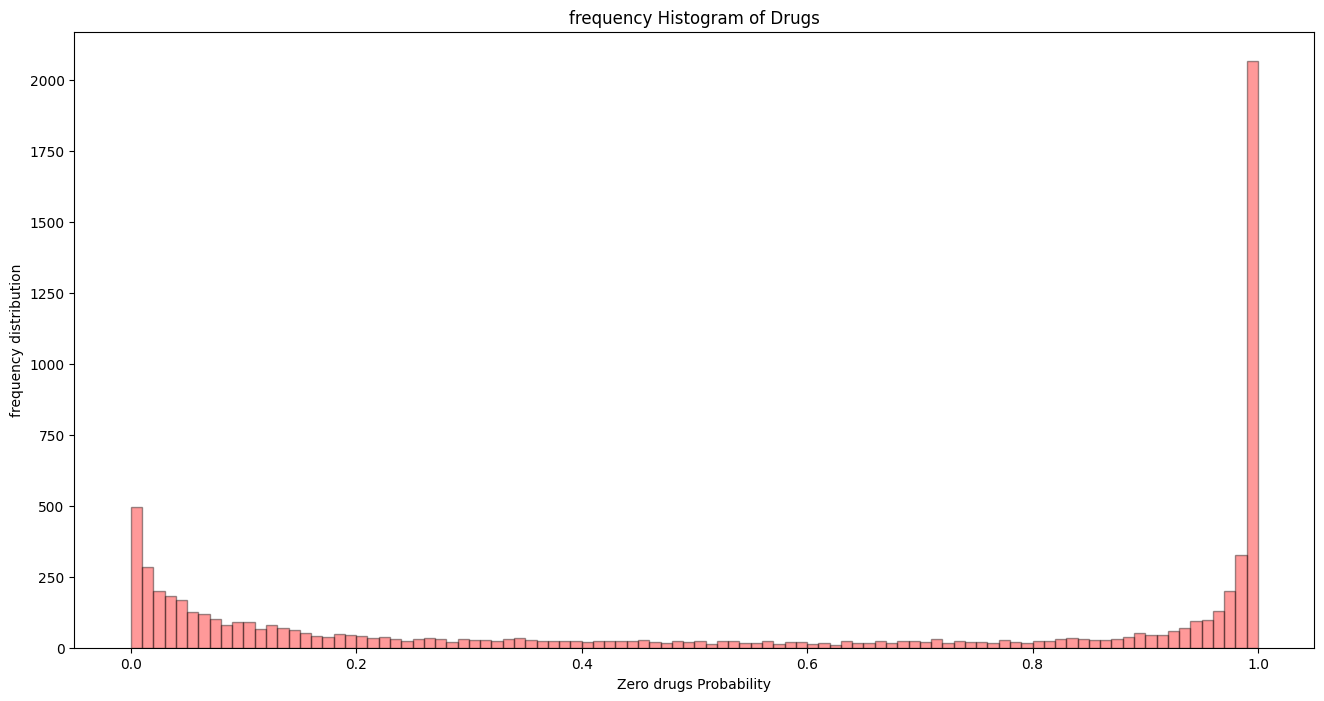

In [35]:

fig, ax = plt.subplots()
fig.set_size_inches(16,8)

# matplotlib histogram
# plt.hist(pd.DataFrame(predit).iloc[:,1], color = 'blue', edgecolor = 'black',
#          bins = int(200))

# seaborn histogram

sns.distplot(pd.DataFrame(predit).iloc[:,2], hist=True, kde=False, 
             bins=int(100), color = 'red',
             hist_kws={'edgecolor':'black'})
# sns.distplot(pd.DataFrame(predit).iloc[:,0], hist=True, kde=True, 
#              bins=int(200), color = 'darkblue', 
#              hist_kws={'edgecolor':'black'},
#              kde_kws={'linewidth': 4})
# Add labels
plt.title('frequency Histogram of Drugs')
plt.xlabel('Zero drugs Probability')
plt.ylabel('frequency distribution')
plt.show()

C:\Users\Akhod\AppData\Local\Temp\ipykernel_18396\1764574696.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pd.DataFrame(predit).iloc[:,1], hist=True, kde=False,
C:\Users\Akhod\AppData\Local\Temp\ipykernel_18396\1764574696.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pd.DataFrame(pr

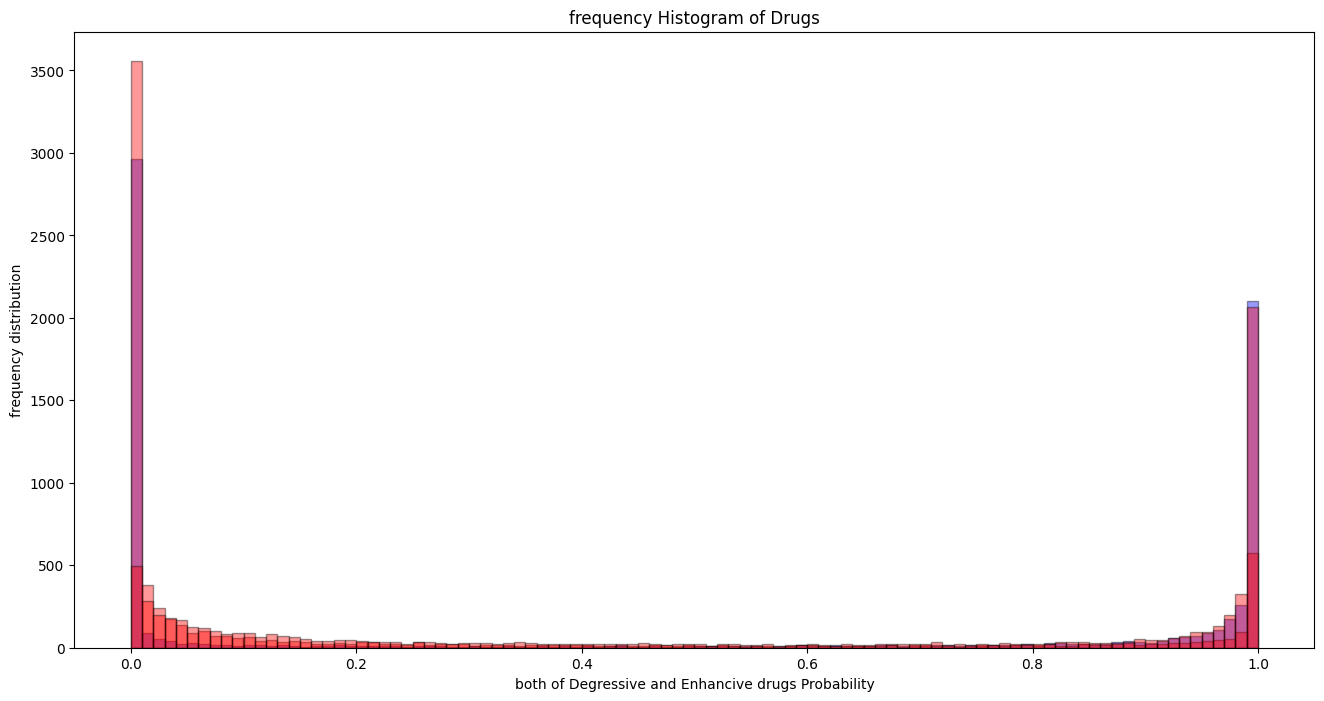

In [38]:

fig, ax = plt.subplots()
fig.set_size_inches(16,8)

# matplotlib histogram
# plt.hist(pd.DataFrame(predit).iloc[:,1], color = 'blue', edgecolor = 'black',
#          bins = int(200))

# seaborn histogram
sns.distplot(pd.DataFrame(predit).iloc[:,1], hist=True, kde=False, 
             bins=int(100), color = 'blue',
             hist_kws={'edgecolor':'black'})

sns.distplot(pd.DataFrame(predit).iloc[:,0], hist=True, kde=False, 
             bins=int(100), color = 'red',
             hist_kws={'edgecolor':'black'})

sns.displot(pd.DataFrame(predit).iloc[:,2], hist=True, kde=False, 
             bins=int(100), color = 'red',
             hist_kws={'edgecolor':'black'})
# sns.distplot(pd.DataFrame(predit).iloc[:,0], hist=True, kde=True, 
#              bins=int(200), color = 'darkblue', 
#              hist_kws={'edgecolor':'black'},
#              kde_kws={'linewidth': 4})
# Add labels
plt.title('frequency Histogram of Drugs')
plt.xlabel('both of Degressive and Enhancive drugs Probability')
plt.ylabel('frequency distribution')
plt.show()